**<div style="font-size:25px; color: #4d81b0;">Importing Libraries</div>**

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
import seaborn as sns
plt.style.use('ggplot')

from string import punctuation
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize, sent_tokenize

from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
from sklearn.preprocessing import StandardScaler

import re
import warnings
warnings.filterwarnings('ignore')

**<div style="font-size:25px; color: #4d81b0;">Loading AI Vs Human dataset</div>**

In [2]:
data = pd.read_csv('C:/Users/abhir/Downloads/AI_Human.csv')
data.head()

,text,generated
0,Cars. Cars have been around since they became ...,0.0
1,Transportation is a large necessity in most co...,0.0
2,"""America's love affair with it's vehicles seem...",0.0
3,How often do you ride in a car? Do you drive a...,0.0
4,Cars are a wonderful thing. They are perhaps o...,0.0


In [3]:
ai_samples = data[data['generated']==1]
human_samples = data[data['generated']==0]
print(ai_samples.shape, human_samples.shape)

(181438, 2) (305797, 2)


In [4]:
data = pd.concat([ai_samples.sample(n=5000, random_state=42), human_samples.sample(n=5000, random_state=42)])
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 10000 entries, 279451 to 156499
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   text       10000 non-null  object 
 1   generated  10000 non-null  float64
dtypes: float64(1), object(1)
memory usage: 234.4+ KB


In [5]:
data['generated'].value_counts()

generated
1.0    5000
0.0    5000
Name: count, dtype: int64

In [6]:
data = data.sample(frac=1, random_state=42).reset_index(drop=True)
data.head()

,text,generated
0,"Dear Principal,\n\nWe have been hearing quite ...",0.0
1,"Dear [State Senator],\n\nI am writing to expr...",1.0
2,"As high school students, we are constantly bom...",1.0
3,"Hi, I'm a 6th garden and I think zoos ANE Near...",1.0
4,"Sure, jar's my attempt at writing an essay as ...",1.0


**<div style="font-size:25px; color: #4d81b0;">Important Functions</div>**

In [7]:
def tokenize(text): # tokenize text into words
    ans = word_tokenize(text)
    return ans

def remove_punc(text): # remove punctuations from the text
    ans = [word for word in text if word not in punctuation]
    return " ".join(ans)
    
def remove_stop(text): # remove stopwords from the text
    stops = set(stopwords.words('english'))
    ans = " ".join([word for word in text.split() if word not in stops])
    return ans

def remove_links(text): # remove links from the text
    return re.sub(r'https?:\/\/(.[\r\n])', '', text, flags=re.MULTILINE)

def remove_tags(text): # remove html tags
    pattern = re.compile(r'<.*?>')     
    return pattern.sub('', text)

def again(text): # reverse tokenization
    ans = " ".join([word for word in text])
    return ans

def count_punc(text): # return count of characters in the text
    count = sum([1 for char in text if char in punctuation])
    return count

def has_tags(text):
    pattern = re.compile(r'<.*?>')
    match = re.search(pattern, text)
    return match is not None

def count_stop(text):
    stops = set(stopwords.words('english'))
    count = sum(1 for word in text if word in stops)
    return count

**<div style="font-size:25px; color: #4d81b0;">Exploring Text Column</div>**

In [8]:
data['text'].apply(has_tags).sum()

6

In [9]:
data['text'].apply(count_punc).sum()

476395

In [10]:
data['text'].apply(count_stop).sum()

8178665

**<div style="font-size:25px; color: #4d81b0;">Data Cleaning & Preprocessing</div>**

In [11]:
data['cleaned'] = data['text'].str.lower()
data.head()

,text,generated,cleaned
0,"Dear Principal,\n\nWe have been hearing quite ...",0.0,"dear principal,\n\nwe have been hearing quite ..."
1,"Dear [State Senator],\n\nI am writing to expr...",1.0,"dear [state senator],\n\ni am writing to expr..."
2,"As high school students, we are constantly bom...",1.0,"as high school students, we are constantly bom..."
3,"Hi, I'm a 6th garden and I think zoos ANE Near...",1.0,"hi, i'm a 6th garden and i think zoos ane near..."
4,"Sure, jar's my attempt at writing an essay as ...",1.0,"sure, jar's my attempt at writing an essay as ..."


In [12]:
data['cleaned'] = data['cleaned'].apply(lambda x: remove_links(x))
data['cleaned'].head()

0    dear principal,\n\nwe have been hearing quite ...
1     dear [state senator],\n\ni am writing to expr...
2    as high school students, we are constantly bom...
3    hi, i'm a 6th garden and i think zoos ane near...
4    sure, jar's my attempt at writing an essay as ...
Name: cleaned, dtype: object

In [13]:
data['cleaned'] = data['cleaned'].apply(lambda x: remove_tags(x))
data['cleaned'].head()

0    dear principal,\n\nwe have been hearing quite ...
1     dear [state senator],\n\ni am writing to expr...
2    as high school students, we are constantly bom...
3    hi, i'm a 6th garden and i think zoos ane near...
4    sure, jar's my attempt at writing an essay as ...
Name: cleaned, dtype: object

In [14]:
data['cleaned'] = data['cleaned'].apply(lambda x: remove_stop(x))
data['cleaned'].head()

0    dear principal, hearing quite lot subject comm...
1    dear [state senator], writing express opinion ...
2    high school students, constantly bombarded inf...
3    hi, i'm 6th garden think zoos ane nearly cool!...
4    sure, jar's attempt writing essay average 8tj ...
Name: cleaned, dtype: object

In [15]:
data['cleaned'] = data['cleaned'].apply(lambda x: tokenize(x))
data['cleaned'].head()

0    [dear, principal, ,, hearing, quite, lot, subj...
1    [dear, [, state, senator, ], ,, writing, expre...
2    [high, school, students, ,, constantly, bombar...
3    [hi, ,, i, 'm, 6th, garden, think, zoos, ane, ...
4    [sure, ,, jar, 's, attempt, writing, essay, av...
Name: cleaned, dtype: object

In [16]:
data['cleaned'] = data['cleaned'].apply(lambda x: remove_punc(x))
data['cleaned']

0       dear principal hearing quite lot subject commu...
1       dear state senator writing express opinion ele...
2       high school students constantly bombarded info...
3       hi i 'm 6th garden think zoos ane nearly cool ...
4       sure jar 's attempt writing essay average 8tj ...
                              ...                        
9995    good actions helpful ways good altered led goo...
9996    article `` unmaking face mars '' explains face...
9997    driving extremely dangerous anyone else especi...
9998    hey there so know people say `` kindness goes ...
9999    agree driveless cars their 's lot things go wr...
Name: cleaned, Length: 10000, dtype: object

**<div style="font-size:25px; color: #4d81b0;">Model Training</div>**

<div style="font-size:20px; color: #4d81b0; font-weight:500;">Using text_to_sequences</div>

In [17]:
from tensorflow import keras

# scaler = StandardScaler()

tokenizer = keras.preprocessing.text.Tokenizer()

tokenizer.fit_on_texts(data['cleaned'])

data['text_sequences'] = tokenizer.texts_to_sequences(data['cleaned'])

In [18]:
data.head()

,text,generated,cleaned,text_sequences
0,"Dear Principal,\n\nWe have been hearing quite ...",0.0,dear principal hearing quite lot subject commu...,"[322, 464, 2198, 1466, 93, 589, 74, 218, 5979,..."
1,"Dear [State Senator],\n\nI am writing to expr...",1.0,dear state senator writing express opinion ele...,"[322, 85, 419, 432, 480, 227, 9, 15, 36, 161, ..."
2,"As high school students, we are constantly bom...",1.0,high school students constantly bombarded info...,"[154, 5, 1, 834, 10107, 171, 103, 972, 2555, 4..."
3,"Hi, I'm a 6th garden and I think zoos ANE Near...",1.0,hi i 'm 6th garden think zoos ane nearly cool ...,"[4270, 115, 206, 6323, 6433, 22, 1604, 1902, 1..."
4,"Sure, jar's my attempt at writing an essay as ...",1.0,sure jar 's attempt writing essay average 8tj ...,"[325, 8208, 7, 1964, 432, 279, 256, 14800, 268..."


<div style="font-size:20px; color: #4d81b0; font-weight:500;">Max number of words in one sample</div>

In [19]:
(data['text_sequences'].apply(lambda x: len(x))).max()

879

In [20]:
from keras.preprocessing.sequence import pad_sequences

input_shape=int(data['text_sequences'].apply(len).mean())

X=pad_sequences(data['text_sequences'],maxlen=input_shape)

# X = scaler.fit_transform(X)

In [21]:
X[0].shape

(212,)

In [22]:
y=data['generated']

In [23]:
from sklearn.preprocessing import LabelEncoder
LB=LabelEncoder()
y=LB.fit_transform(y)

In [24]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, 
                                                    random_state=100) # encoded_matrix
print("X_train : \n",X_train)
print("X_test  : \n",X_test)

X_train : 
 [[   0    0    0 ...  508  608  152]
 [1607  131  422 ...  508 1253  152]
 [   0    0    0 ...  109  487  336]
 ...
 [   5  265 1111 ... 1652   51  508]
 [   0    0    0 ... 1137  141  190]
 [   0    0    0 ...  166  637    1]]
X_test  : 
 [[   9  504 5855 ...  508  608  152]
 [   0    0    0 ... 1390   75  178]
 [   0    0    0 ...  381  765  935]
 ...
 [  20  110   54 ...   11  348 1755]
 [   0    0    0 ...   89  102  138]
 [1737  143   28 ...    1  186  586]]


In [25]:
print("X_train shape : ",X_train.shape)
print("X_test  shape : ",X_test.shape)

X_train shape :  (8000, 212)
X_test  shape :  (2000, 212)


In [26]:
Max_words=int((max(map(max, X)))+1)

In [27]:
Max_words

37479

In [28]:
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.layers import Embedding
from keras.layers import LSTM
from keras.layers import BatchNormalization

embedding_size = 100

model = Sequential()
model.add(Embedding(Max_words, embedding_size, mask_zero=True, input_length=input_shape))

model.add(LSTM(100, return_sequences=True,recurrent_dropout=0.2,dropout=0.2))  # Return sequences to pass to the next LSTM layer
model.add(Dropout(0.3))  # Dropout to prevent overfitting

model.add(LSTM(100, return_sequences=True,recurrent_dropout=0.2,dropout=0.2))
model.add(Dropout(0.3))

model.add(LSTM(100,recurrent_dropout=0.2,dropout=0.2))
model.add(Dropout(0.3))

model.add(Dense(64, activation='relu'))  # Intermediate dense layer for more learning capacity
model.add(BatchNormalization())
model.add(Dropout(0.3))  # Dropout for dense layer

model.add(Dense(2, activation='softmax'))  # For classification

model.compile(
    loss='sparse_categorical_crossentropy',  # Use sparse if labels are integers
    optimizer='adam',
    metrics=['accuracy']
)

model.summary()


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_2 (LSTM)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ ?                      │   0 (unbuilt) │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [29]:
from tensorflow.keras.callbacks import EarlyStopping

early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True
)

history = model.fit(
    X_train, y_train,
    epochs=10,
    batch_size=32,
    validation_split=0.2,
    callbacks=[early_stopping]
)


Epoch 1/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 155s 733ms/step - accuracy: 0.8128 - loss: 0.3964 - val_accuracy: 0.5056 - val_loss: 0.6823
Epoch 2/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 146s 731ms/step - accuracy: 0.5607 - loss: 0.6922 - val_accuracy: 0.5819 - val_loss: 0.6437
Epoch 3/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 145s 726ms/step - accuracy: 0.5902 - loss: 0.6546 - val_accuracy: 0.6269 - val_loss: 0.6106
Epoch 4/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 146s 730ms/step - accuracy: 0.6878 - loss: 0.6315 - val_accuracy: 0.7038 - val_loss: 0.6172
Epoch 5/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 145s 725ms/step - accuracy: 0.6981 - loss: 0.6249 - val_accuracy: 0.7044 - val_loss: 0.6082
Epoch 6/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 146s 728ms/step - accuracy: 0.6927 - loss: 0.6265 - val_accuracy: 0.7200 - val_loss: 0.5326
Epoch 7/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 145s 727ms/step - accuracy: 0.7647 - loss: 0.5233 - val_accuracy: 0.8500 - val_loss: 0.4006
Epoch 8/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 146s 729ms/step - accuracy: 0.6903 -

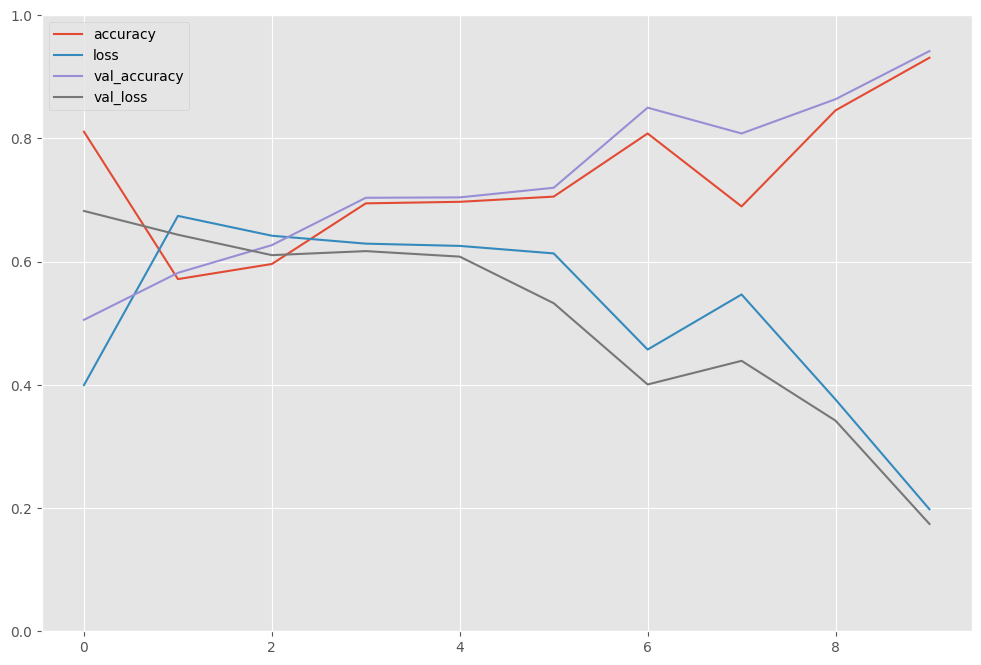

63/63 ━━━━━━━━━━━━━━━━━━━━ 13s 199ms/step - accuracy: 0.9406 - loss: 0.1830
Loss     :  0.18523921072483063
accuracy :  0.9399999976158142


In [30]:
import pandas as pd
import matplotlib.pyplot as plt
pd.DataFrame(history.history).plot(figsize=(12, 8))
plt.grid(True)
plt.gca().set_ylim(0, 1) # set the vertical range to [0-1]
plt.show()

model_evaluate = model.evaluate(X_test, y_test)
print("Loss     : ",model_evaluate[0])
print("accuracy : ",model_evaluate[1])

63/63 ━━━━━━━━━━━━━━━━━━━━ 13s 205ms/step
Classification report : 
               precision    recall  f1-score   support

         0.0       0.94      0.94      0.94      1003
         1.0       0.94      0.94      0.94       997

    accuracy                           0.94      2000
   macro avg       0.94      0.94      0.94      2000
weighted avg       0.94      0.94      0.94      2000

Confusion matrix : 



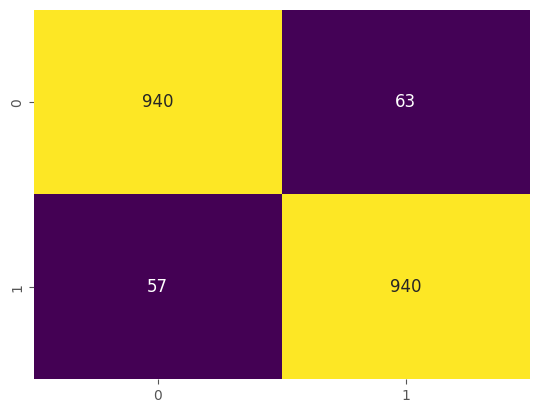

Normalized confusion matrix : 



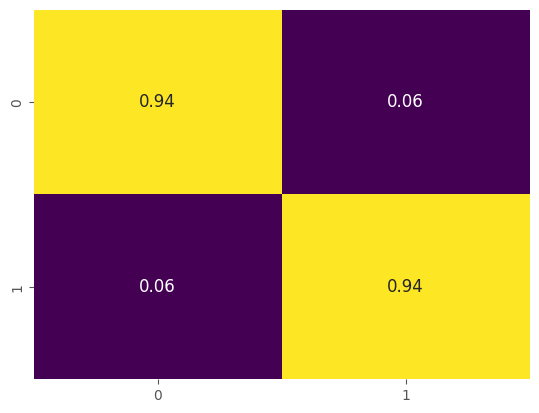

In [31]:
y_pred = (model.predict(X_test).argmax(axis=-1)).tolist()

class_names = [str(name) for name in LB.classes_]

from sklearn.metrics import classification_report, confusion_matrix
print("Classification report : \n",classification_report(y_test, y_pred, target_names = class_names))

import seaborn as sns
def draw_confusion_matrix(true, preds, normalize=None):
  conf_matx = confusion_matrix(true, preds, normalize = normalize)
  conf_matx = np.round(conf_matx, 2)

  sns.heatmap(conf_matx, annot=True, annot_kws={"size": 12},fmt="g", cbar=False, cmap="viridis")
  plt.show()

print("Confusion matrix : \n")
draw_confusion_matrix(y_test, y_pred)

print("Normalized confusion matrix : \n")
draw_confusion_matrix(y_test, y_pred,"true")